In [1]:
# import packages
from gru.example_printer import ExamplePrinter
from gru.dataset import GRUDataset
from gru.gru_v3 import EncoderNet, DecoderNet, EncoderDecoder
from vectorizer import SELFIESVectorizer, determine_alphabet
from gru.cce import CCE, ConsciousCrossEntropy
from split import scaffold_split
from tqdm import tqdm

import torch
import wandb
import pandas as pd
import random

# weights and biases
!wandb login 505ce3ad45fdf9309c3d8ec1d9764262ae6929c1

wandb: Appending key for api.wandb.ai to your netrc file: /home/hubert/.netrc


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data prep

In [15]:
alphabet = pd.read_csv('./GRU_data/alphabet.txt', header=None).values.flatten()
vectorizer = SELFIESVectorizer(alphabet, pad_to_len=128)

#data_path = './GRU_data/combned_dataset.parquet'
#dataset = pd.read_parquet(data_path)

#train_size = 0.9

#train_df, val_df = scaffold_split(dataset, train_size)

train_df = pd.read_parquet('./models/v3-revisited/train_dataset.parquet')
val_df = pd.read_parquet('./models/v3-revisited/val_dataset.parquet')

train_dataset = GRUDataset(train_df, vectorizer)
val_dataset = GRUDataset(val_df, vectorizer)

#print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Train size: 1093607
Val size: 121524


In [16]:
from torch.utils.data import DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

# Parameters

In [17]:
run_name = 'v3-revisited'

# Set hyperparameters
encoding_size = 512
hidden_size = 512
num_layers = 1
learn_rate = 0.0003
dropout = 0 # dropout must be equal 0 if num_layers = 1
teacher_ratio = 0.5

# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    teacher_ratio = teacher_ratio).to(device)

#! mkdir ./models/{run_name}
#train_df.to_parquet(f'./models/{run_name}/train_dataset.parquet', index=False)
#val_df.to_parquet(f'./models/{run_name}/val_dataset.parquet', index=False)

In [18]:
model.load_state_dict(torch.load('./GRU_data/params/v3_w-teacher-w-enumeration-0.pt'))

<All keys matched successfully>

# Training loop

In [19]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, vectorizer, device):

    EPOCHS = 25

    # Define dataframe for training progess display
    epochs_range = range(1,EPOCHS+1)
    metrics = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss']);
    metrics['epoch'] = epochs_range
    
    # Init example printer
    printer = ExamplePrinter(val_loader, 25)

    # Define pyplot for plotting metrics
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display(fig, display_id=True)

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = CCE()

    # wandb config and init
    config = dict()
    config['learning rate'] = learn_rate
    config['encoding size'] = model.encoding_size
    config['criterion'] = criterion
    config['optimizer'] = optimizer
    config['num epochs'] = EPOCHS
    config['Trainable parameters'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    config['hidden size'] = model.hidden_size
    config['Number of layers'] = num_layers
    config['Dropout'] = model.decoder.dropout
    config['Batch size'] = batch_size
    config['teacher_ratio'] = teacher_ratio
    wandb.init(project="encoded-token-concat", config=config)

    print("Starting Training of GRU")
    print(f"Device: {device}")
    
    samples = []
    
    # Start training loop
    for epoch in epochs_range:
        print(f'Epoch: {epoch}')
        epoch_loss = 0
        model.train()
        for batch_idx, (X,y) in enumerate(tqdm(train_loader)):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X, y, teacher_forcing=True).to(device)
            loss = criterion(y, output)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # calculate loss and log to wandb
        avg_loss = epoch_loss / len(train_loader)
        val_loss = evaluate(model, val_loader)
        metrics_dict = {'epoch': epoch,
                        'train_loss': avg_loss,
                        'val_loss': val_loss}
        wandb.log(metrics_dict)

        # Update metrics df
        metrics.loc[len(metrics)] = metrics_dict

        # Display metrics
        ax[0].clear()
        ax[0].plot(metrics.epoch, metrics.train_loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('CrossEntropy')
        ax[1].clear()
        ax[1].plot(metrics.epoch, metrics.val_loss)
        ax[1].set_title('validation loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('CrossEntropy')
        dh.update(fig)
        
        try:
            new_samples = printer(model)
            samples.append(new_samples)
        except:
            pass
        
        save_path = f"./models/{run_name}/model_epoch_{epoch}.pt"
        torch.save(model.state_dict(),save_path)
        
    plt.close()
    wandb.finish()
    return model, samples

def evaluate(model, val_loader):
    model.eval()
    criterion = ConsciousCrossEntropy()
    epoch_loss = 0
    for batch_idx, (X, y) in enumerate(val_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X, y, teacher_forcing=False).to(device)
        loss = criterion(y, output)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(val_loader)
    return avg_loss

# Train the model

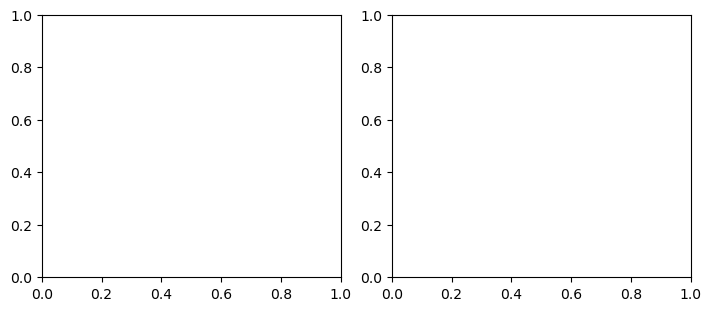

epoch,▁
train_loss,▁
val_loss,▁
epoch,1
train_loss,0.37324
val_loss,0.80066


Starting Training of GRU
Device: cuda
Epoch: 1


  0%|                                        | 1/4271 [00:01<1:37:37,  1.37s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.95 GiB total capacity; 1.37 GiB already allocated; 10.62 MiB free; 1.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

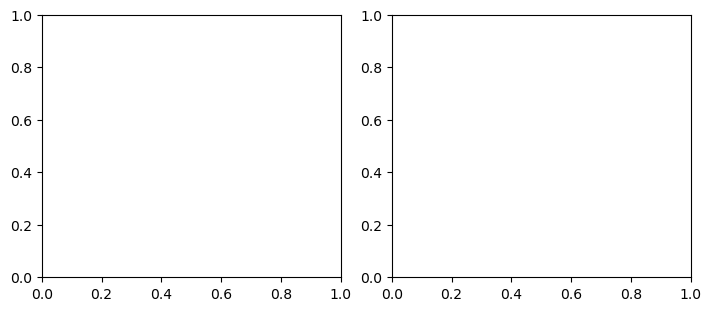

In [20]:
model, samples = train(model, train_loader, val_loader, vectorizer, device)

# save model
save_path = f"./models/{run_name}/model_final.pt"
torch.save(model.state_dict(), save_path)